
## 0. Importation des bibliothèques


In [3]:
!pip install arabic-reshaper python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 14.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
import seaborn as sns
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

## 1. Données de fusion :
##### Notre ensemble de données est basé sur le fichier csv d'origine, la structure du mème incluant également les fusionnés pour créer cet ensemble de données.

In [5]:
data = pd.read_csv("archive_arabic_news/Akhbarona.ma.csv")
data2 = pd.read_csv("archive_arabic_news/Hespress.ma.csv")
data3 = pd.read_csv("archive_arabic_news/Hibapress.com.csv")
data4 = pd.read_csv("archive_arabic_news/Le360.com.csv")

In [ ]:
data.head(1)

,Title,Body,Category
0,البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وه...,أخبارنا المغربية : سناء الوردي لازالت الحكومة ...,Business


In [ ]:
data2.head(1)

,Title,Body,Category
0,زايو .. المدينة اليتيمة التي لا تعرفها غالبيّة...,زايو أو المدينة اليتيمة، لا زالت ضمن المدن الم...,Regions


In [ ]:
data3.head(1)

,Title,Body,Category
0,الهند.. ارتفاع حصيلة ضحايا حادث دهس القطار إلى...,أعلن رئيس وزراء ولاية بنجاب شمال الهند، أمارين...,International


In [ ]:
data4.head(1)

,Title,Body,Category
0,محللون: هل تخرج قوانين الاتحاد الإفريقي البرلم...,بعد مصادقة المجلس الوزاري، أمس، على القانون ال...,Policy


In [ ]:
# Fusionner les deux DataFrames (concaténer verticalement)
df_merged = pd.concat([data, data2, data3, data4], ignore_index=True)

# Sauvegarder le résultat dans un nouveau fichier CSV
df_merged.to_csv('data_arabic_news.csv', index=False)

print(f"Fusion terminée ! Nombre total de lignes : {len(df_merged)}")

Fusion terminée ! Nombre total de lignes : 418563



## 2. Chargement du corpus


##### data_arabic_news.csv est la fusion des deux fichiers csv

In [ ]:
data_complete = pd.read_csv("data_arabic_news.csv")
data_complete.head()


# 3. Pour notre modele on besoin seulement de Article text et Category

In [7]:
data = data_complete[['Body', 'Category']]

In [ ]:
data['Category'].value_counts()

Category
Sport            77231
Society          77163
Events           45625
Policy           44521
International    28199
World            27526
Business         23548
Regions          22827
Culture          15966
National         13538
Influencers      10908
Immigrants       10904
Women             5153
Environment       4441
Tech              3668
Health            3612
Education         1430
Tamazight         1075
Religion           844
Cars               384
Name: count, dtype: int64

# 4. Suppresion des valeurs manquantes

In [ ]:
# Compter les valeurs manquantes par colonne
print("=== Nombre de valeurs manquantes par colonne ===")
print(data.isnull().sum())

=== Nombre de valeurs manquantes par colonne ===
Body        0
Category    0
dtype: int64


#### **pas de valeurs manquantes , mais il fallait verifier**


## 4. Visualisation : Nuages de mots par catégorie
#### mots arabe et WordCloud ne gère PAS l’arabe nativement

In [ ]:
data_sample = data.sample(frac=0.25, random_state=42)

In [ ]:
import re

def keep_arabic(text):
    return " ".join(re.findall(r'[\u0600-\u06FF]+', text))

In [ ]:
MAX_CHARS = 20000

In [ ]:
for category in data_sample['Category'].unique():

    text = " ".join(
        data_sample[data_sample['Category'] == category]['Body']
        .dropna()
        .astype(str)
    )

    # Garder uniquement l'arabe
    text = keep_arabic(text)

    # Limiter la taille pour éviter les erreurs
    text = text[:20000]

    if len(text.strip()) == 0:
        continue

    try:
        reshaped_text = arabic_reshaper.reshape(text)
        bidi_text = get_display(reshaped_text)
    except Exception as e:
        print(f"Erreur pour la catégorie {category}: {e}")
        continue

    wc = WordCloud(
        width=600,
        height=300,
        background_color='white',
        font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
        max_words=120
    ).generate(bidi_text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nuage de mots - {category}")
    plt.show()

## **Ici les mots n'apparait pas sainement juste de charabia** so j'ai arreter l'exection


## 5. Visualisation : Répartition des catégories


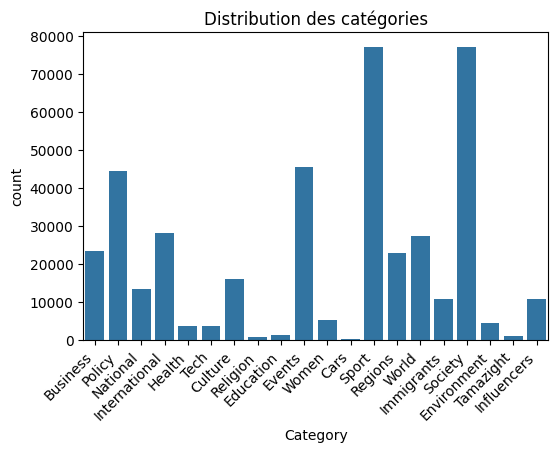

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x="Category")
plt.title("Distribution des catégories")
plt.xticks(rotation=45, ha='right')  # rotation des labels
plt.show()

## 6.Préparation des données

In [ ]:
data['Category'].value_counts()

Category
Sport            77231
Society          77163
Events           45625
Policy           44521
International    28199
World            27526
Business         23548
Regions          22827
Culture          15966
National         13538
Influencers      10908
Immigrants       10904
Women             5153
Environment       4441
Tech              3668
Health            3612
Education         1430
Tamazight         1075
Religion           844
Cars               384
Name: count, dtype: int64

In [8]:
X = data['Body']
y= data['Category']

### 2. Divise dataset en donnees d'entrainement et donnees de test:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train:", len(X_train))
print("Test:", len(X_test))

Train: 334850
Test: 83713



## 7. Prétraitement du texte : Vectorisation avec TF-IDF


In [10]:
nltk.download('stopwords')
arabic_stopwords = stopwords.words('arabic')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
tfidf = TfidfVectorizer(
    stop_words=arabic_stopwords,
    max_features=5000,
    ngram_range=(1, 2),        # utile en arabe
    token_pattern=r'(?u)\b\w+\b'
)

# FIT_TRANSFORM sur train
X_train_vec = tfidf.fit_transform(X_train)

# TRANSFORM sur test
X_test_vec = tfidf.transform(X_test)

print(f"Shape X_train_vec: {X_train_vec.shape}")
print(f"Shape X_test_vec: {X_test_vec.shape}")
print(f"Vocabulaire: {len(tfidf.vocabulary_)} mots")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Shape X_train_vec: (334850, 5000)
Shape X_test_vec: (83713, 5000)
Vocabulaire: 5000 mots


## 8. Visualisation de la Vectorisation TF-IDF

In [12]:
articles_messages = [
    X_test.iloc[0], X_test.iloc[1], X_test.iloc[2], X_test.iloc[3]
]

# Transformation des exemples
articles_vec = tfidf.transform(articles_messages)
feature_names = tfidf.get_feature_names_out()


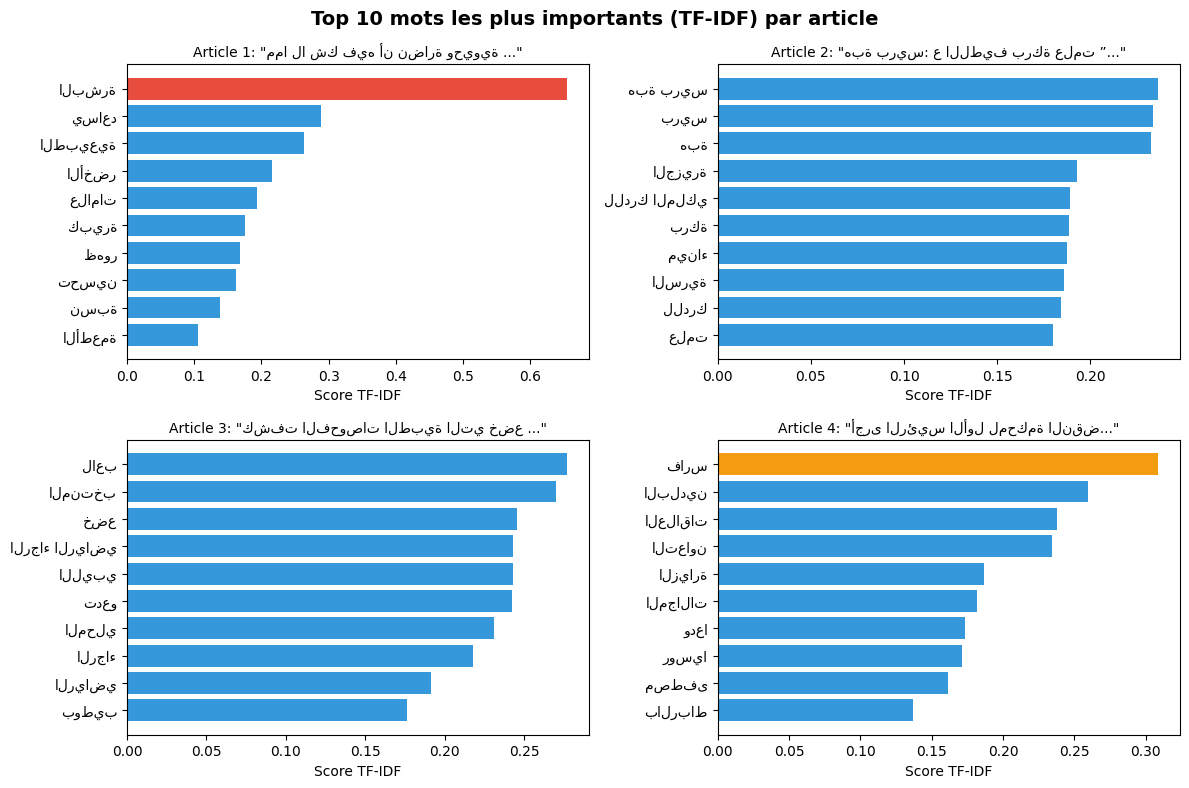

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, article in enumerate(articles_messages):
    vec = articles_vec[i].toarray()[0]
    non_zero_idx = np.where(vec > 0)[0]

    mots = [feature_names[idx] for idx in non_zero_idx]
    scores = [vec[idx] for idx in non_zero_idx]

    # Trier par score décroissant
    sorted_pairs = sorted(zip(mots, scores), key=lambda x: x[1], reverse=True)

    # GARDER SEULEMENT LES 10 PREMIERS
    sorted_pairs = sorted_pairs[:10]

    if sorted_pairs:
        mots, scores = zip(*sorted_pairs)

        colors = ['#e74c3c' if s > 0.4 else '#f39c12' if s > 0.3 else '#3498db' for s in scores]
        axes[i].barh(mots, scores, color=colors)
        axes[i].set_xlabel('Score TF-IDF')
        axes[i].set_title(f'Article {i+1}: "{article[:30]}..."' if len(article) > 30 else f'Article {i+1}: "{article}"', fontsize=10)
        axes[i].invert_yaxis()

plt.suptitle('Top 10 mots les plus importants (TF-IDF) par article', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 9. Entraînement du modèle


In [14]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

## 10. Prédiction et évaluation

In [15]:
y_pred = model.predict(X_test_vec)

### Accuracy:

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy :", accuracy)

Accuracy : 0.6704573961033531


### Rapport de classification

In [17]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.61      0.75      0.68      4749
         Cars       0.96      0.30      0.45        74
      Culture       0.65      0.76      0.70      3217
    Education       0.31      0.37      0.34       310
  Environment       0.46      0.26      0.33       879
       Events       0.63      0.81      0.71      9152
       Health       0.49      0.63      0.55       695
   Immigrants       0.70      0.20      0.32      2218
  Influencers       0.68      0.67      0.67      2146
International       0.58      0.56      0.57      5536
     National       0.45      0.11      0.17      2698
       Policy       0.65      0.81      0.72      8921
      Regions       0.64      0.59      0.62      4557
     Religion       0.54      0.57      0.56       154
      Society       0.62      0.47      0.54     15494
        Sport       0.85      0.95      0.89     15433
    Tamazight       0.78      0.39      0.52       202
         


## 11. Sauvegarde et téléchargement du modèle


In [21]:
import joblib

# Sauvegarde du modèle Naive Bayes
joblib.dump(model, "model/naive_bayes_model_arabic.pkl")

# Sauvegarde du vectorizer TF-IDF
joblib.dump(tfidf, "model/tfidf_vectorizer_arabic.pkl")

print("Modèle Naive Bayes et vectorizer sauvegardés avec succès.")


Modèle Naive Bayes et vectorizer sauvegardés avec succès.


In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Construction du modèle GRU
#### Les réseaux GRU (Gated Recurrent Units) sont adaptés au traitement des séquences textuelles car ils permettent de capturer les dépendances contextuelles entre les mots
#### Ici on a pas utilisee TF-IDF , car  TF-IDF n’est pas adapté aux modèles séquentiels comme les GRU, car il perd l’ordre des mots, alors que les GRU ont justement besoin de l’information séquentielle.

### 1.Prétraitement pour GRU

In [25]:
stop_words = set(stopwords.words('arabic'))

def clean_text(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

X = [clean_text(text) for text in X]

In [26]:
print(stop_words)

{'نَّ', 'ثمة', 'ذلك', 'لهم', 'تِي', 'ب', 'أفريل', 'ن', 'ذلكم', 'كلّما', 'بمن', 'رابع', 'هَاتِه', 'فضلا', 'لسنا', 'أوت', 'ثم', 'سبت', 'ليسوا', 'خاء', 'ألا', 'مكانكنّ', 'كأنّ', 'تفعلان', 'ته', 'وَيْ', 'أطعم', 'ح', 'ذان', 'لنا', 'اللائي', 'ألف', 'رجع', 'تسعمائة', 'جنيه', 'ين', 'غدا', 'فو', 'راء', 'ليت', 'آها', 'لعلَّ', 'أربعاء', 'رويدك', 'آ', 'لم', 'ليرة', 'تِه', 'حدَث', 'شتان', 'أنتِ', 'فرادى', 'خمسون', 'أي', 'مافتئ', 'انقلب', 'هذي', 'سنتيم', 'عشر', 'بما', 'هاتان', 'م', 'قطّ', 'ما', 'لا', 'دونك', 'صار', 'أمامك', 'إذاً', 'خامس', 'هاتي', 'لما', 'يفعلون', 'تلكم', 'اربعون', 'إلى', 'حاء', 'مارس', 'جير', 'ثلاثمئة', 'تبدّل', 'أين', 'ميم', 'ذال', 'ت', 'لدى', 'بهن', 'فلا', 'لك', 'أكتوبر', 'نبَّا', 'إنَّ', 'الذي', 'حار', 'يفعلان', 'أيّ', 'أنًّ', 'تي', 'لوما', 'ة', 'قاطبة', 'ثمنمئة', 'أبدا', 'ص', 'تسعين', 'سرعان', 'هذه', 'ذلكن', 'نيسان', 'ثامن', 'هلا', 'آمينَ', 'واحد', 'حمٌ', 'شباط', 'لعمر', 'سبعون', 'اللتيا', 'اثنين', 'أبريل', 'ألفى', 'بس', 'أنت', 'اتخذ', 'تخذ', 'عاشر', 'أُفٍّ', 'عشرة', 'حزيران', 

In [28]:
# Tokenization
tokenizer_gru = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer_gru.fit_on_texts(data['Body'])

sequences = tokenizer_gru.texts_to_sequences(data['Body'])
X = pad_sequences(sequences, maxlen=300, padding='post')

# Labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['Category'])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 2.Modèle GRU

In [29]:
num_classes = len(set(y))

model_gru = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=300),
    GRU(64, kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model_gru.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 3.Entraînement du GRU

In [30]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [31]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/10
9418/9418 ━━━━━━━━━━━━━━━━━━━━ 165s 17ms/step - accuracy: 0.4241 - loss: 1.7976 - val_accuracy: 0.6795 - val_loss: 0.9568
Epoch 2/10
9418/9418 ━━━━━━━━━━━━━━━━━━━━ 149s 16ms/step - accuracy: 0.7047 - loss: 0.9102 - val_accuracy: 0.7325 - val_loss: 0.8069
Epoch 3/10
9418/9418 ━━━━━━━━━━━━━━━━━━━━ 150s 16ms/step - accuracy: 0.7379 - loss: 0.7963 - val_accuracy: 0.7421 - val_loss: 0.7715
Epoch 4/10
9418/9418 ━━━━━━━━━━━━━━━━━━━━ 146s 15ms/step - accuracy: 0.7597 - loss: 0.7348 - val_accuracy: 0.7515 - val_loss: 0.7418
Epoch 5/10
9418/9418 ━━━━━━━━━━━━━━━━━━━━ 150s 16ms/step - accuracy: 0.7758 - loss: 0.6874 - val_accuracy: 0.7519 - val_loss: 0.7438
Epoch 6/10
9418/9418 ━━━━━━━━━━━━━━━━━━━━ 150s 16ms/step - accuracy: 0.7857 - loss: 0.6598 - val_accuracy: 0.7525 - val_loss: 0.7385
Epoch 7/10
9418/9418 ━━━━━━━━━━━━━━━━━━━━ 157s 17ms/step - accuracy: 0.7953 - loss: 0.6265 - val_accuracy: 0.7558 - val_loss: 0.7455
Epoch 8/10
9418/9418 ━━━━━━━━━━━━━━━━━━━━ 154s 16ms/step - accuracy: 

### 4.Évaluation du modèle GRU

In [32]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_pred_gru = np.argmax(model_gru.predict(X_test), axis=1)

print("Accuracy GRU:", accuracy_score(y_test, y_pred_gru))
print(classification_report(y_test, y_pred_gru, target_names=encoder.classes_))

2617/2617 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
Accuracy GRU: 0.7567283456571858
               precision    recall  f1-score   support

     Business       0.72      0.73      0.72      4749
         Cars       0.69      0.55      0.62        74
      Culture       0.69      0.81      0.74      3217
    Education       0.59      0.47      0.52       310
  Environment       0.49      0.41      0.45       879
       Events       0.76      0.83      0.79      9152
       Health       0.56      0.66      0.61       695
   Immigrants       0.66      0.72      0.69      2218
  Influencers       0.73      0.77      0.75      2146
International       0.63      0.71      0.67      5536
     National       0.65      0.44      0.53      2698
       Policy       0.76      0.78      0.77      8921
      Regions       0.69      0.72      0.70      4557
     Religion       0.72      0.46      0.56       154
      Society       0.75      0.68      0.71     15494
        Sport       0.92      0.94      0.

### 5.Visualisation Accuracy & Loss (GRU)

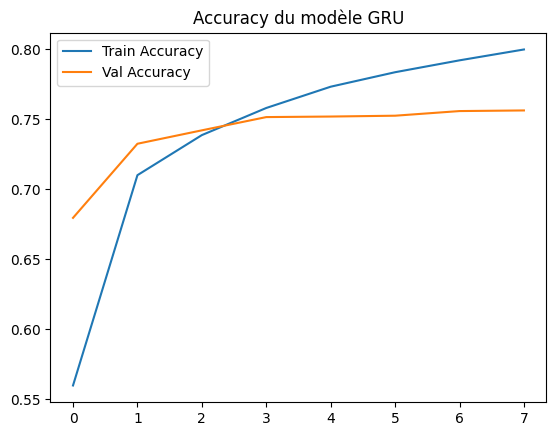

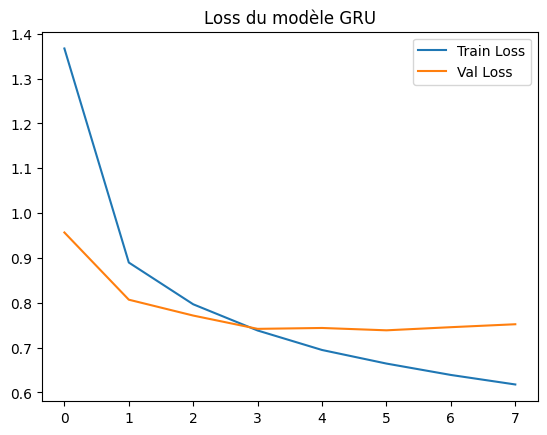

In [33]:
# Accuracy
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy du modèle GRU")
plt.legend()
plt.show()

# Loss
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title("Loss du modèle GRU")
plt.legend()
plt.show()

### 6.Sauvegarde du modèle GRU

In [ ]:
# Sauvegarde du modèle
model_gru.save("model/gru_news_model_arabic.h5")

# Sauvegarde du tokenizer
import pickle
with open("model/tokenizer_gru_arabic.pkl", "wb") as f:
    pickle.dump(tokenizer_gru, f)

# Sauvegarde du label encoder
with open("model/label_encoder_arabic.pkl", "wb") as f:
    pickle.dump(encoder, f)

print("Modèle GRU sauvegardé avec succès")

✅ Modèle GRU sauvegardé avec succès
